In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from chromalab.observer import Observer, Cone, transformToChromaticity, getHeringMatrix
from chromalab.spectra import Spectra, Illuminant, convert_refs_to_spectras
from chromalab.maxbasis import MaxBasis
from chromalab.visualizer import PSWrapper, DisplayBasisType, exportAndPlay, easeFunction

objc[61426]: Class GLFWApplicationDelegate is implemented in both /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-packages/open3d/cpu/pybind.cpython-311-darwin.so (0x2a27c2e28) and /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-packages/polyscope_bindings.cpython-311-darwin.so (0x2bc9c2ea0). One of the two will be used. Which one is undefined.
objc[61426]: Class GLFWWindowDelegate is implemented in both /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-packages/open3d/cpu/pybind.cpython-311-darwin.so (0x2a27c2db0) and /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-packages/polyscope_bindings.cpython-311-darwin.so (0x2bc9c2ec8). One of the two will be used. Which one is undefined.
objc[61426]: Class GLFWContentView is implemented in both /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-packages/open3d/cpu/pybind.cpython-311-darwin.so (0x2a27c2e50) and /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [4]:
wavelengths1 = np.arange(390, 701, 1)
wavelengths5 = np.arange(400, 701, 5)
wavelengths10 = np.arange(400, 701, 10)

In [5]:
wavelengths = np.arange(400, 710, 10)
d65 = Illuminant.get("D65")

In [6]:
trichromat = Observer.trichromat(wavelengths=wavelengths5, illuminant=d65) 
maxbasis_tri = MaxBasis(trichromat, verbose=True)
# viz_tri = PSWrapper(trichromat, maxbasis_tri, itemsToDisplay=PSWrapper.ItemsToDisplay.MESH, displayBasis=DisplayBasisType.MAXBASIS, verbose=True)

tetrachromat = Observer.tetrachromat(wavelengths=wavelengths, illuminant=d65, verbose=True) 
maxbasis = MaxBasis(tetrachromat, verbose=True)
viz = PSWrapper(tetrachromat, maxbasis, itemsToDisplay=PSWrapper.ItemsToDisplay.BOTH, displayBasis=DisplayBasisType.MAXBASIS, verbose=True) 

100%|██████████| 58/58 [00:00<00:00, 616.20it/s]
/Users/jessicalee/Projects/generalized-colorimetry/code/ChromaLab/chromalab/spectra.py:36: UserWarning: Data has values not between 0 and 1. Clipping.
  warnings.warn("Data has values not between 0 and 1. Clipping.")
100%|██████████| 28/28 [00:00<00:00, 50.34it/s]


[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.1 Metal - 83.1


100%|██████████| 8990/8990 [00:19<00:00, 455.19it/s]


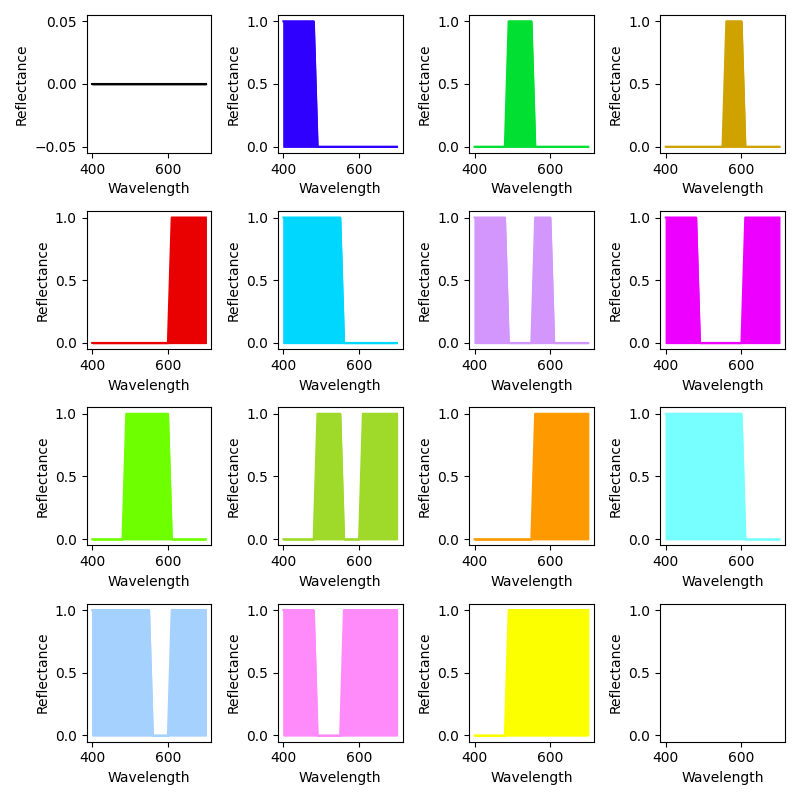

: 

In [20]:
refs, discrete_points, rgbs, lines = maxbasis.getDiscreteRepresentation()
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

for i in range(4):
    for j in range(4):
        axs[i, j].plot(wavelengths, refs[i*4+j].data, c=rgbs[i*4 + j])
        axs[i, j].fill_between(wavelengths, refs[i*4+j].data, color=rgbs[i*4 + j])
        axs[i, j].set_xlabel('Wavelength')
        axs[i, j].set_ylabel('Reflectance')
        # axs[i, j].set_title(f'Ref {i*4+j}')

plt.tight_layout()
plt.show()


In [8]:
# helper functions

order = ['mesh', 'lattice', 'qarrow']
def SetEnabledFn(list_names, list_types=None):
    if list_types is None:
        return lambda list_true: [viz.ps.get_surface_mesh(item).set_enabled(enabled) for item, enabled in zip(list_names, list_true)]
    else:
        return lambda list_true: [getattr(viz.ps, f'get_{type_name}')(item).set_enabled(enabled) for item, type_name, enabled in zip(list_names, list_types, list_true)]

def doNothing(j):
    pass

def FadeIn(name, total_frames, opacity_range=[0, 1]):
    def fadeIn(j):
        viz.ps.get_surface_mesh(name).set_transparency(easeFunction(j/total_frames)*(opacity_range[1] - opacity_range[0])  + opacity_range[0])
    return fadeIn

def FadeOut(name, total_frames, opacity_range=[0, 1]):
    def fadeOut(j):
        viz.ps.get_surface_mesh(name).set_transparency(opacity_range[1]-(easeFunction(j/total_frames)*(opacity_range[1] - opacity_range[0])))
    return fadeOut


def RotateAroundZ(total_frames, r, theta, phi_range, lookAt=[0, 0, 0]):
    def rotateAroundZ(j):
        phi = phi_range[0] + (phi_range[1] - phi_range[0]) * j / total_frames
        point_3d = PSWrapper.polarToCartesian(r, theta, phi)
        viz.ps.look_at(point_3d, lookAt)
    return rotateAroundZ

def RotateTheta(total_frames, r, theta_range, phi, lookAt=[0, 0, 0]):
    def moveAlongTheta(j):
        theta = theta_range[0] + (theta_range[1] - theta_range[0]) * j / total_frames
        point_3d = PSWrapper.polarToCartesian(r, theta, phi)
        viz.ps.look_at(point_3d, lookAt)
    return moveAlongTheta

def MoveAlongPath(total_frames, r_phi_thetas, lookAt=[0, 0, 0]): 
    r_theta_phi_interpolated = PSWrapper.getPathPoints(r_phi_thetas, total_frames, method='arc')
    def moveAlongPath(j):
        r, theta, phi = r_theta_phi_interpolated[j]
        point_3d = PSWrapper.polarToCartesian(r, theta, phi)
        viz.ps.look_at(point_3d, lookAt)
    return moveAlongPath

In [9]:
# general settings
viz.ps.set_ground_plane_mode("none")
dirname = "./outputs/presentation_loop"
offset = 0

# render all objects
viz.renderObjectsPS(mesh_alpha=0.8, lattice_alpha=1)
viz.renderQArrow()

# transform to correct dir
mat = viz._getTransformQUpDir()
viz.ps.get_surface_mesh("mesh").set_transform(mat)
viz.ps.get_surface_mesh("lattice").set_transform(mat)
viz.ps.get_surface_mesh("qarrow").set_transform(mat)

In [11]:
set_enabled = SetEnabledFn(order)

In [12]:
# 1. comparison with trichromatic chromatic space
set_enabled([True, False, False])

long_frames = 30 * 3
r = 4
theta = 65
rotAroundZ = RotateAroundZ(long_frames, r, theta, [0, 360])
offset = viz.renderScreenshots(rotAroundZ, dirname, long_frames, offset)

In [13]:
# 2. Q direction
set_enabled([True, False, True])
fadeInQArrow = FadeIn("qarrow", long_frames)
phi = 90
rotAroundZ = RotateAroundZ(long_frames, r, theta, [0, phi])

def rotateAndFade(i):
    fadeInQArrow(i)
    rotAroundZ(i)

offset = viz.renderScreenshots(rotateAndFade, dirname, long_frames, offset)

short_frames = 30
rotateTheta = RotateTheta(short_frames, r, [theta, 0.1], phi)
offset = viz.renderScreenshots(rotateTheta, dirname, short_frames, offset)

offset = viz.renderScreenshots(doNothing, dirname, short_frames, offset)

theta = 90
rotateTheta = RotateTheta(short_frames, r, [0.1, theta], phi)
offset = viz.renderScreenshots(rotateTheta, dirname, short_frames, offset)

offset = viz.renderScreenshots(doNothing, dirname, short_frames, offset)

In [14]:
# 3. Confusion Lines (nails in a bed animation)
name_grid_arrows = viz.renderGridOfArrows(flip_arrow_dir=True)[0]
name_flattened_mesh = viz.renderFlattened4DMesh(-1.25)[0]
viz.ps.get_surface_mesh(name_grid_arrows).set_enabled(False)
viz.ps.get_surface_mesh(name_flattened_mesh).set_enabled(False)
set_enabled([True, False, False])

rotAroundZ = RotateAroundZ(long_frames, r, theta, [phi, phi+90])
fadeInGridArrows = FadeIn(name_grid_arrows, long_frames, opacity_range=[0.2, 1])
fadeInFlattenedMesh = FadeIn(name_flattened_mesh, long_frames, opacity_range=[0.2, 1])
fadeInMesh = FadeIn("mesh", long_frames, opacity_range=[0.8, 1])
phi = phi + 90

def rotateAndFadeIn(i):
    if i == long_frames//5:
        viz.ps.get_surface_mesh(name_grid_arrows).set_enabled(True)
        viz.ps.get_surface_mesh(name_flattened_mesh).set_enabled(True)
    fadeInGridArrows(i)
    fadeInFlattenedMesh(i)
    fadeInMesh(i)
    rotAroundZ(i)

# rotate rightwards along phi and fade in the view
offset = viz.renderScreenshots(rotateAndFadeIn, dirname, long_frames, offset)

# go up and down on theta to show the confusion lines
rotateTheta = RotateTheta(short_frames, r, [theta, 0.1], phi)
offset = viz.renderScreenshots(rotateTheta, dirname, short_frames, offset)

rotateTheta = RotateTheta(short_frames, r, [0.1, theta], phi)
offset = viz.renderScreenshots(rotateTheta, dirname, short_frames, offset)

# rotate again and fade out
rotAroundZ = RotateAroundZ(long_frames, r, theta, [phi, phi+90])
fadeOutGridArrows = FadeOut(name_grid_arrows, long_frames)
fadeOutFlattenedMesh = FadeOut(name_flattened_mesh, long_frames)
fadeOutMesh = FadeOut("mesh", long_frames, opacity_range=[0.8, 1])
phi = phi + 90

def rotateAndFadeOut(i):
    if i == long_frames - long_frames//5:
        viz.ps.get_surface_mesh(name_grid_arrows).set_enabled(False)
        viz.ps.get_surface_mesh(name_flattened_mesh).set_enabled(False)
    fadeOutGridArrows(i)
    fadeOutFlattenedMesh(i)
    fadeOutMesh(i)
    rotAroundZ(i)
offset = viz.renderScreenshots(rotateAndFadeOut, dirname, long_frames, offset)

In [15]:
# 5. Then, Lattice with Mesh, with Mesh and Lattice Alpha going down as it reaches Orange
set_enabled([True, True, False])
ref_points = (mat[:3, :3]@((viz.HMatrix@discrete_points.T)[1:, :])).T

magenta = ref_points[7]
orange = ref_points[10]

r_theta_phis = [orange, magenta]
polar = np.array([PSWrapper.cartesianToPolar(v[0], v[1], v[2]) for v in r_theta_phis])
polar[:, 0] = r

last_phi = polar[-1, -1]
path = [[r, theta, phi]] + polar.tolist()

moveAlongToOrange = MoveAlongPath(short_frames, path[:2], lookAt=[0, 0, 0])
fadeInLattice = FadeIn("lattice", short_frames, opacity_range=[0.3, 1])

def moveToOrange(i):
    moveAlongToOrange(i)
    fadeInLattice(i)

offset = viz.renderScreenshots(moveToOrange, dirname, short_frames, offset)

In [16]:
# 6. Fade out and move to magenta
# fade back in mesh and rotate to magenta
def FadeOutThenInMesh(offset):
    fadeOutMesh = FadeOut("mesh", short_frames, [0.3, 0.8])
    offset = viz.renderScreenshots(fadeOutMesh, dirname, short_frames, offset)

    fadeInMesh = FadeIn("mesh", short_frames, [0.3, 0.8])
    offset= viz.renderScreenshots(fadeInMesh, dirname, short_frames, offset)
    return offset

offset = FadeOutThenInMesh(offset)

moveAlongToMagenta = MoveAlongPath(short_frames, path[1:], lookAt=[0, 0, 0])
offset = viz.renderScreenshots(moveAlongToMagenta, dirname, short_frames, offset)

offset = FadeOutThenInMesh(offset)

In [17]:
# 7. Hue Sphere is an extension of the FM100 test
# rotate to Z down
set_enabled([True, True, True])
fadeInQArrow = FadeIn("qarrow", short_frames, [0.3, 1])
offset = viz.renderScreenshots(fadeInQArrow, dirname, short_frames, offset)

path = [polar[-1] ] + [[r, 0, phi]]
moveAlongToZDown = MoveAlongPath(short_frames, path, lookAt=[0, 0, 0])
offset = viz.renderScreenshots(moveAlongToZDown, dirname, short_frames, offset)

offset = FadeOutThenInMesh(offset)

In [18]:
exportAndPlay(dirname)

ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex 